# Overview of Latent Semantic Indexing

## Running example

In [1]:
from collections import Counter
import numpy as np
from IPython.core.display import display, HTML


def data_to_table(D):
    row = "<th>DocId</th><th>Tokens</th>"
    table = "<table><tr>"+row+"</tr>"
    for i, doc in enumerate(D):
        row = "<tr><td>" + str(i) + "</td><td>"+" ".join(doc)+'</td>'+"</tr>"
        table += row
    table += '</table>'
    return table 

def near_tables(t1, t2):
    p = "<style>table,td,tr,th {border:none!important} th {border-bottom:solid!important}</style>"
    p += "<table><tr><td style='vertical-align: top;'>"
    p += t1 + "</td><td style='vertical-align: top;'>"
    p += t2 + "</td></tr></table>"
    return p

def to_table(tokens, M, rnd=3, bold_th=0.0):
    row = "<th></th>" + "".join(['<th style="text-align: center;">'+str(x)+'</th>' for x in range(0, M.shape[1])])
    table = "<table><tr>"+row+"</tr>"
    for i, token in enumerate(M):
        cells = []
        for x in token:
            if x > bold_th:
                s = "font-weight: bold; background-color: #eeee00;"
            else:
                s = "font-weight: normal;"
            cell = '<td style="text-align: center; '+s+'">'+str(round(x, rnd))+'</td>'
            cells.append(cell)
        row = "<tr><td style='text-align: right;'>" + tokens[i] + "</td>"+"".join(cells)+"</tr>"
        table += row
    table += '</table>'
    return table

def model(tokens, docs, tf_idf=False):
    dictionary, tf = {}, {}
    for i, d in enumerate(docs):
        tf[i] = dict(Counter(d).most_common())
        for k in tf[i].keys():
            try:
                dictionary[k] += 1
            except KeyError:
                dictionary[k] = 1
    M = np.zeros((len(tokens), len(docs)))
    for i in range(0, len(tokens)):
        k = tokens[i]
        for j, d in enumerate(docs):
            try:
                tfw = float(tf[j][k])
            except KeyError:
                tfw = 0
            if tf_idf:
                M[i,j] = tfw * (np.log(float(len(docs) / dictionary[k])))
            else:
                M[i,j] = tfw
    return M

In [2]:
dataset = [
    ['apple', 'ios', 'mac', 'book'],
    ['apple', 'mac', 'book', 'apple', 'store'],
    ['microsoft', 'ibm', 'apple', 'oracle'],
    ['microsoft', 'book', 'store'],
    ['mac', 'book', 'store'],
    ['apple', 'banana', 'mango', 'fruit'],
    ['apple', 'fruit'],
    ['banana', 'apple', 'orange', 'strawberry']
]

tokens = set()
for d in dataset:
    for t in d:
        tokens.add(t)
tokens = sorted(list(tokens))

T = model(tokens, dataset)

so = []
for i, row in enumerate(T):
    sk = sum(row[5:])
    so.append((i, sk))
so = sorted(so, key=lambda x: x[1])
Ts = np.zeros(T.shape)
stokens = []
for k, j in enumerate([x[0] for x in so]):
    Ts[k] = T[j]
    stokens.append(tokens[j])

In [3]:
display(HTML(near_tables(data_to_table(dataset), to_table(tokens, T))))

In [4]:
display(HTML(near_tables(data_to_table(dataset), to_table(stokens, Ts))))

# SVD
full_matrices : bool, optional
If True (default), u and v have the shapes (M, M) and (N, N), respectively. Otherwise, the shapes are (M, K) and (K, N), respectively, where K = min(M, N). The v returned by this function is V.T and u = U.

In [5]:
U, s, VT = np.linalg.svd(T, full_matrices=False)
Sigma = np.diag(s)
print 'original shape', T.shape
print 'U shape', U.shape
print 'Sigma shape', Sigma.shape
print 'VT shape', VT.shape

original shape (13, 8)
U shape (13, 8)
Sigma shape (8, 8)
VT shape (8, 8)


The terms in the new space are represented by the row vectors of $U$ whereas the documents by the column vectors of
$V^T$.

In [6]:
t1, t2 = to_table(tokens, U, bold_th=10), to_table([str(i) for i in range(0, len(dataset))], VT.T, bold_th=10)
display(HTML(near_tables(t1, t2)))

,0,1,2,3,4,5,6,7
apple,-0.722,-0.394,-0.055,-0.194,0.259,-0.331,0.13,-0.299
banana,-0.142,-0.392,0.18,0.381,-0.227,0.318,-0.294,-0.097
book,-0.413,0.457,0.079,0.1,-0.133,0.28,0.183,-0.029
fruit,-0.132,-0.323,0.112,-0.361,-0.497,0.045,0.324,0.618
ibm,-0.067,-0.076,-0.469,-0.051,0.129,0.089,-0.31,0.261
ios,-0.11,0.071,0.11,-0.16,0.297,0.632,0.292,-0.06
mac,-0.356,0.312,0.249,-0.126,0.23,0.118,-0.425,0.368
mango,-0.073,-0.209,0.096,-0.127,-0.389,0.303,-0.413,-0.334
microsoft,-0.125,0.069,-0.639,0.175,-0.233,0.251,0.299,-0.136
oracle,-0.067,-0.076,-0.469,-0.051,0.129,0.089,-0.31,0.261


## Select dimensions

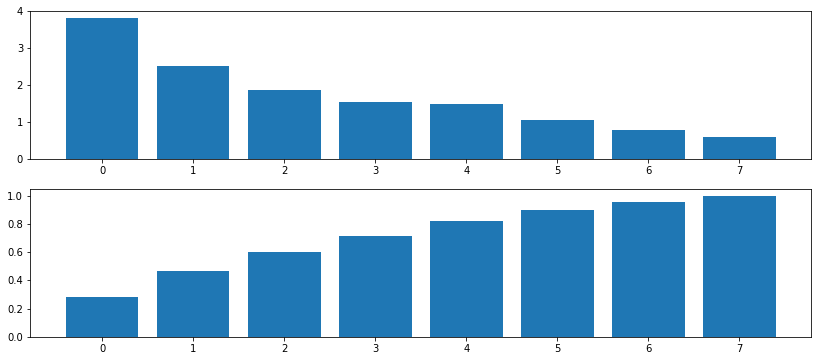

In [12]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))
axes[0].bar(range(0, len(s)), s)
axes[1].bar(range(0, len(s)), np.cumsum(s) / s.sum())
plt.show()

In [13]:
K = 2
sk = s[:K]
Uk = U[:,:K]
VTk = VT[:K,:]
Tred = np.dot(np.dot(Uk, np.diag(sk)), VTk)

In [14]:
tk1, tk2 = to_table(tokens, Uk, bold_th=10), to_table([str(i) for i in range(0, len(dataset))], VTk.T, bold_th=10)
display(HTML(near_tables(near_tables(tk1, tk2), to_table(tokens, Tred, bold_th=10))))

,0,1
apple,-0.722,-0.394
banana,-0.142,-0.392
book,-0.413,0.457
fruit,-0.132,-0.323
ibm,-0.067,-0.076
ios,-0.11,0.071
mac,-0.356,0.312
mango,-0.073,-0.209
microsoft,-0.125,0.069
oracle,-0.067,-0.076


## Getting term vectors

In [15]:
Terms = np.dot(Uk, np.diag(sk))
Docs = np.dot(np.diag(sk), VTk)

tk3, tk4 = to_table(tokens, Terms, bold_th=10), to_table([str(i) for i in range(0, len(dataset))], Docs.T, bold_th=10)
display(HTML(near_tables(tk3, tk4)))

,0,1
apple,-2.759,-0.99
banana,-0.542,-0.984
book,-1.579,1.147
fruit,-0.503,-0.811
ibm,-0.257,-0.19
ios,-0.419,0.177
mac,-1.359,0.783
mango,-0.28,-0.525
microsoft,-0.477,0.174
oracle,-0.257,-0.19


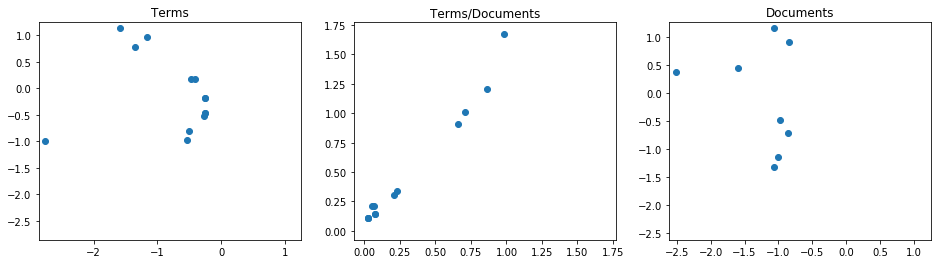

In [16]:
if K == 2:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
    axes[0].scatter(Terms[:,0], Terms[:,1])
    a0l = (min(min(Terms[:,0])-0.1, min(Terms[:,1])-0.1), max(max(Terms[:,0])+0.1, max(Terms[:,1])+0.1))
    axes[0].set_title('Terms')
    axes[0].set_ylim(a0l)
    axes[0].set_xlim(a0l)
    axes[1].scatter(Tred[:,0], Tred[:,1])
    a1l = (min(min(Tred[:,0])-0.1, min(Tred[:,1])-0.1), max(max(Tred[:,0])+0.1, max(Tred[:,1])+0.1))
    axes[1].set_title('Terms/Documents')
    axes[1].set_ylim(a1l)
    axes[1].set_xlim(a1l)
    axes[2].scatter(Docs.T[:,0], Docs.T[:,1])
    axes[2].set_title('Documents')
    a2l = (min(min(Docs.T[:,0])-0.1, min(Docs.T[:,1])-0.1), max(max(Docs.T[:,0])+0.1, max(Docs.T[:,1])+0.1))
    axes[2].set_ylim(a2l)
    axes[2].set_xlim(a2l)
    plt.show()

## Query

In [18]:
from scipy.spatial.distance import cosine

q = ['ibm', 'store']
qv = np.array([Terms[tokens.index(x)] for x in q])
qs = np.mean(qv, axis=0)
answers = []
for i, d in enumerate(Docs.T):
    sim = 1-cosine(qs, d)
    answers.append((dataset[i], sim))
for a in sorted(answers, key=lambda x: -x[1]):
    print a

(['apple', 'ios', 'mac', 'book'], 0.9732624843298584)
(['mac', 'book', 'store'], 0.94944976611691401)
(['microsoft', 'book', 'store'], 0.94849694173668087)
(['apple', 'mac', 'book', 'apple', 'store'], 0.93644173874550929)
(['microsoft', 'ibm', 'apple', 'oracle'], 0.57789087289313956)
(['apple', 'fruit'], 0.36088519874382163)
(['banana', 'apple', 'orange', 'strawberry'], 0.21109802926065013)
(['apple', 'banana', 'mango', 'fruit'], 0.17744863655044996)


In [19]:
topic1 = Terms[:,1].T

In [20]:
print topic1

[-0.98965072 -0.98369166  1.14670401 -0.81069827 -0.18965995  0.17736137
  0.78340671 -0.52504228  0.17363736 -0.18965995 -0.45864937  0.96934264
 -0.45864937]


In [21]:
topic_pos = sorted([(x, y) for x, y in enumerate(topic1)], 
                   key=lambda k: -np.abs(k[1]))
print [(tokens[i], w) for i, w in topic_pos[:4]]

[('book', 1.1467040140627376), ('apple', -0.9896507230254431), ('banana', -0.98369165719806395), ('store', 0.96934264408010262)]
